<a href="https://colab.research.google.com/github/lnsprnz/MantisAI/blob/main/Mantis_keypoint_detection_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# mantis Keypoint Detection with Transfer Learning

**Description:** Training a keypoint detector with data augmentation and transfer learning. Based on https://keras.io/examples/vision/keypoint_detection/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install the imgaug package

In [ ]:
!pip install -q -U imgaug
!pip install -q -U keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 47.0 MB/s eta 0:00:00


In [ ]:
from keras import layers
import keras

from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa

from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import json
import os

# Define hyperparameters:
IMG_SIZE: length and width of the Mantis Images

BATCH_SIZE

EPOCH

NUM_KEYPOINTS: Number of Keypoints to detect. In this work we need to detect 5 Keypoints

In [ ]:
IMG_SIZE = 640
BATCH_SIZE = 10
EPOCHS = 50
NUM_KEYPOINTS = 5 * 2  # 5 pairs each having x and y coordinates

## Load data

The authors also provide a metadata file that specifies additional information about the
keypoints, like color information, animal pose name, etc. We will load this file in a `pandas`
dataframe to extract information for visualization purposes.

In [ ]:
IMG_DIR = "/content/drive/MyDrive/MantisImages220"
JSON = "/content/drive/MyDrive/MantisAnnotations220.json"
KEYPOINT_DEF = (
    "/content/drive/MyDrive/MantisKeypointDef.csv"
)

# Load the ground-truth annotations.
with open(JSON) as infile:
    json_data = json.load(infile)

# Prepare the mapping for images and annotations
images = {image['id']: image for image in json_data['images']}
annotations = {annotation['image_id']: annotation for annotation in json_data['annotations']}

# Process keypoints to ensure they are 2D
raw_keypoints = annotations.get('keypoints', [])
if raw_keypoints:
  # Reshape the keypoints into a 2D array with shape (num_keypoints, 3)
  reshaped_keypoints = [raw_keypoints[i:i + 3] for i in range(0, len(raw_keypoints), 3)]
else:
  reshaped_keypoints = []

# Generate the desired output structure
json_dict = {}
for image_id, image_data in images.items():
    annotation = annotations.get(image_id, {})

    #convert joints to 2D Array
    keypoints = annotation.get('keypoints', [])
    joints_2d = np.array(keypoints).reshape(-1, 3) if keypoints else []

    # Map the image and annotation data to the desired structure
    json_dict[image_data['file_name']] = {
        'img_bbox': annotation.get('bbox', []),
        'img_height': image_data['height'],
        'img_path': image_data['file_name'],
        'img_width': image_data['width'],
        'joints': joints_2d.tolist()
    }

# Example: Accessing a single entry from json_dict
for path, entry in json_dict.items():
    print(f"'{path}': {entry}")
    joints = entry.get('joints', [])
    joints_array = np.array(joints)

    # Print the information
    print(f"Image Path: {path}")
    print(f"Joints Array:\n{joints_array}")
    print(f"Shape: {joints_array.shape}")
    break  # Just show one example


'Hyosicorypha_gracilis_D8_F4_S4_23-08-01vll_C001H001S0001001966_jpg.rf.0fc0b90dd1bd154211b939e42b970262.jpg': {'img_bbox': [211, 278, 536, 379], 'img_height': 1024, 'img_path': 'Hyosicorypha_gracilis_D8_F4_S4_23-08-01vll_C001H001S0001001966_jpg.rf.0fc0b90dd1bd154211b939e42b970262.jpg', 'img_width': 1024, 'joints': [[720.385, 373.077, 2.0], [429.615, 475.0, 2.0], [453.462, 294.231, 2.0], [401.923, 505.0, 2.0], [328.077, 501.154, 2.0]]}
Image Path: Hyosicorypha_gracilis_D8_F4_S4_23-08-01vll_C001H001S0001001966_jpg.rf.0fc0b90dd1bd154211b939e42b970262.jpg
Joints Array:
[[720.385 373.077   2.   ]
 [429.615 475.      2.   ]
 [453.462 294.231   2.   ]
 [401.923 505.      2.   ]
 [328.077 501.154   2.   ]]
Shape: (5, 3)


In this example, the keys we are interested in are:

* `img_path`
* `joints`

There are a total of 5 entries present inside `joints`. Each entry has 3 values:

* x-coordinate
* y-coordinate
* visibility flag of the keypoints (always set to 2)



In [ ]:
# Load the metdata definition file and preview it.
keypoint_def = pd.read_csv(KEYPOINT_DEF)
keypoint_def.head()

# Extract the colours and labels.
colours = keypoint_def["Hex color"].values.tolist()
colours = ["#" + colour for colour in colours]
labels = keypoint_def["Name"].values.tolist()


# Utility for reading an image and for getting its annotations.
def get_mantis(name):
    data = json_dict[name]
    img_data = plt.imread(os.path.join(IMG_DIR, data["img_path"]))
    # If the image is RGBA convert it to RGB.
    if img_data.shape[-1] == 4:
        img_data = img_data.astype(np.uint8)
        img_data = Image.fromarray(img_data)
        img_data = np.array(img_data.convert("RGB"))
    data["img_data"] = img_data

    return data


## Visualize data

Now, we write a utility function to visualize the images and their keypoints.

In [ ]:

# Parts of this code come from here:
# https://github.com/benjiebob/StanfordExtra/blob/master/demo.ipynb
def visualize_keypoints(images, keypoints):
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(10, 15))
    [ax.axis("off") for ax in np.ravel(axes)]

    for (ax_orig, ax_all), image, current_keypoint in zip(axes, images, keypoints):
        ax_orig.imshow(image)
        ax_all.imshow(image)

        # If the keypoints were formed by `imgaug` then the coordinates need
        # to be iterated differently.
        if isinstance(current_keypoint, KeypointsOnImage):
            x_coords = []
            y_coords = []
            for idx, kp in enumerate(current_keypoint.keypoints):
                ax_all.scatter(
                    [kp.x],
                    [kp.y],
                    c=colours[idx],
                    marker="x",
                    s=50,
                    linewidths=5,
                )
                x_coords.append(kp.x)
                y_coords.append(kp.y)
            # Draw lines connecting the keypoints in sequence 0->1->2->3->4
            for i in range(len(x_coords) - 1):
                ax_all.plot([x_coords[i], x_coords[i + 1]], [y_coords[i], y_coords[i + 1]], c="g", linewidth=1)
        else:
            current_keypoint = np.array(current_keypoint)
            current_keypoint = current_keypoint[:, :2]
            x_coords, y_coords = [], []
            for idx, (x, y) in enumerate(current_keypoint):
              ax_all.scatter([x], [y], c=colours[idx], marker=".", s=10, linewidths=2)
              x_coords.append(x)
              y_coords.append(y)
            for i in range(len(x_coords) - 1):
                ax_all.plot([x_coords[i], x_coords[i + 1]], [y_coords[i], y_coords[i + 1]], c="g", linewidth=1)
    plt.tight_layout(pad=2.0)
    plt.show()

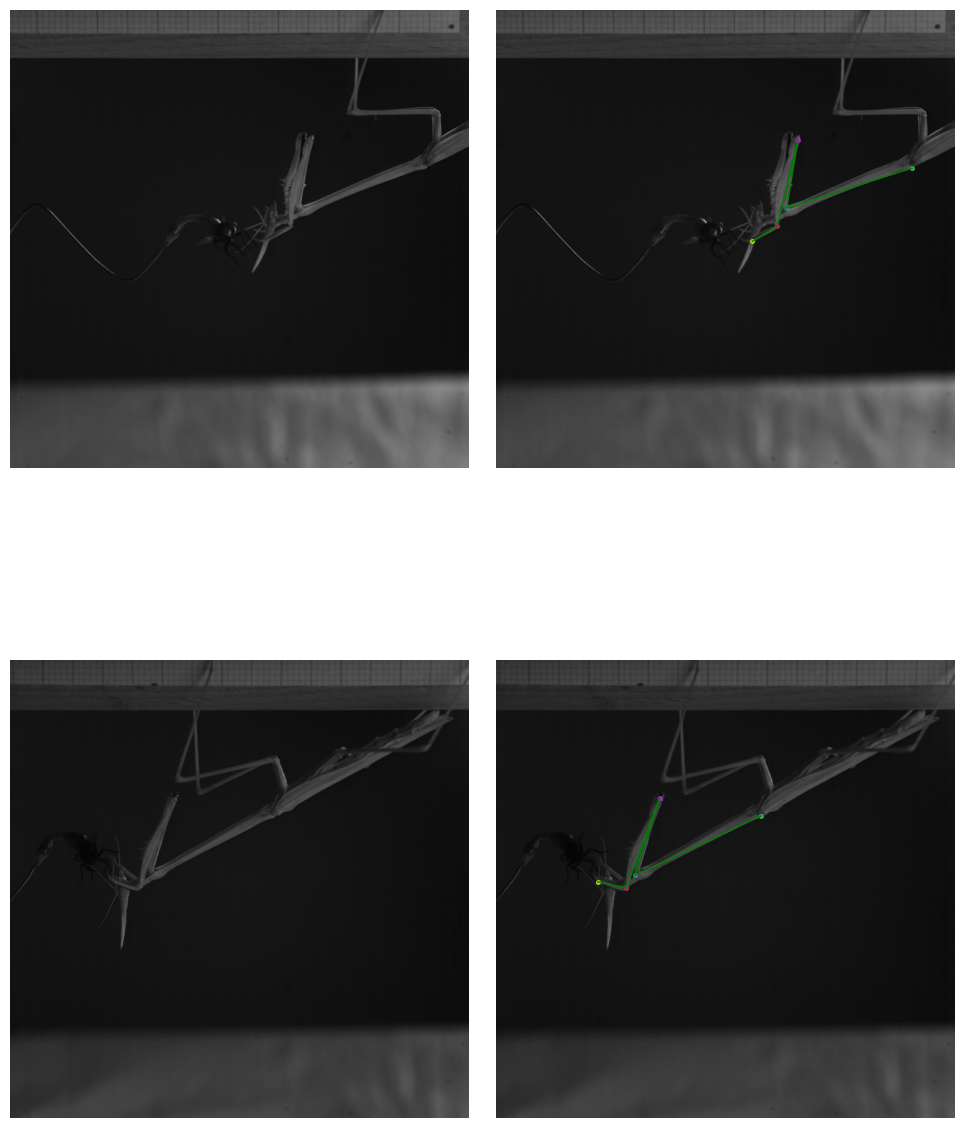

In [ ]:
# Select four samples randomly for visualization.
samples = list(json_dict.keys())
num_samples = 2
selected_samples = np.random.choice(samples, num_samples, replace=False)

images, keypoints = [], []

for sample in selected_samples:
    data = get_mantis(sample)
    image = data["img_data"]
    keypoint = data["joints"]

    images.append(image)
    keypoints.append(keypoint)

visualize_keypoints(images, keypoints)

In the next section, we will write a data generator inheriting the
[`keras.utils.Sequence`](https://keras.io/api/utils/python_utils/#sequence-class) class
that applies data augmentation on batches of data using `imgaug`.

## Prepare data generator

In [ ]:

class KeyPointsDataset(keras.utils.PyDataset):
    def __init__(self, image_keys, aug, batch_size=BATCH_SIZE, train=True, **kwargs):
        super().__init__(**kwargs)
        self.image_keys = image_keys
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_keys) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_keys))
        if self.train:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        image_keys_temp = [self.image_keys[k] for k in indexes]
        (images, keypoints) = self.__data_generation(image_keys_temp)

        return (images, keypoints)

    def __data_generation(self, image_keys_temp):
        batch_images = np.empty((self.batch_size, IMG_SIZE, IMG_SIZE, 3), dtype="int")
        batch_keypoints = np.empty(
            (self.batch_size, 1, 1, NUM_KEYPOINTS), dtype="float32"
        )

        for i, key in enumerate(image_keys_temp):
            data = get_mantis(key)
            current_keypoint = np.array(data["joints"])[:, :2]
            kps = []

            #print(f"Shape: {current_keypoint.shape}")

            # To apply our data augmentation pipeline, we first need to
            # form Keypoint objects with the original coordinates.
            for j in range(0, len(current_keypoint)):
                kps.append(Keypoint(x=current_keypoint[j][0], y=current_keypoint[j][1]))

            # We then project the original image and its keypoint coordinates.
            current_image = data["img_data"]
            kps_obj = KeypointsOnImage(kps, shape=current_image.shape)

            # Apply the augmentation pipeline.
            (new_image, new_kps_obj) = self.aug(image=current_image, keypoints=kps_obj)
            batch_images[i,] = new_image

            # Parse the coordinates from the new keypoint object.
            kp_temp = []
            for keypoint in new_kps_obj:
                kp_temp.append(np.nan_to_num(keypoint.x))
                kp_temp.append(np.nan_to_num(keypoint.y))

            # More on why this reshaping later.
            batch_keypoints[i,] = np.array(kp_temp).reshape(1, 1, 5 * 2)

            #print(f"IMG_SIZE: {IMG_SIZE}")
            #print(f"Batch keypoints before normalization: {batch_keypoints}")
            #print(f"Batch keypoints after normalization: {batch_keypoints / IMG_SIZE}")

        # Scale the coordinates to [0, 1] range.
        batch_keypoints = batch_keypoints / IMG_SIZE

        return (batch_images, batch_keypoints)


To know more about how to operate with keypoints in `imgaug` check out
[this document](https://imgaug.readthedocs.io/en/latest/source/examples_keypoints.html).

## Define augmentation transforms

In [ ]:
train_aug = iaa.Sequential(
    [
        iaa.Resize(IMG_SIZE, interpolation="linear"),
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        iaa.Sometimes(0.5, iaa.Affine(rotate=(-45,45))),
        iaa.Sometimes(0.5, iaa.Affine(scale={"x": (0.5, 1.5), "y": (0.5, 1.5)}))
    ]
)

test_aug = iaa.Sequential([iaa.Resize(IMG_SIZE, interpolation="linear")])

## Create training, validation & test splits

In [ ]:
np.random.shuffle(samples)
# Define split ratios
train_ratio = 150/220  # 70% training
validation_ratio = 35/220  # 15% validation
test_ratio = 35/220  # 15% test

# Indices for splits
train_idx = int(len(samples) * train_ratio)
validation_idx = train_idx + int(len(samples) * validation_ratio)

# Split dataset
train_keys = samples[:train_idx]
validation_keys = samples[train_idx:validation_idx]
test_keys = samples[validation_idx:]

# Output split sizes
print(f"Training set size: {len(train_keys)}")
print(f"Validation set size: {len(validation_keys)}")
print(f"Test set size: {len(test_keys)}")


Training set size: 150
Validation set size: 35
Test set size: 35


## Data generator investigation

Total batches in training set: 15
Total batches in validation set: 3
Total batches in test set: 3


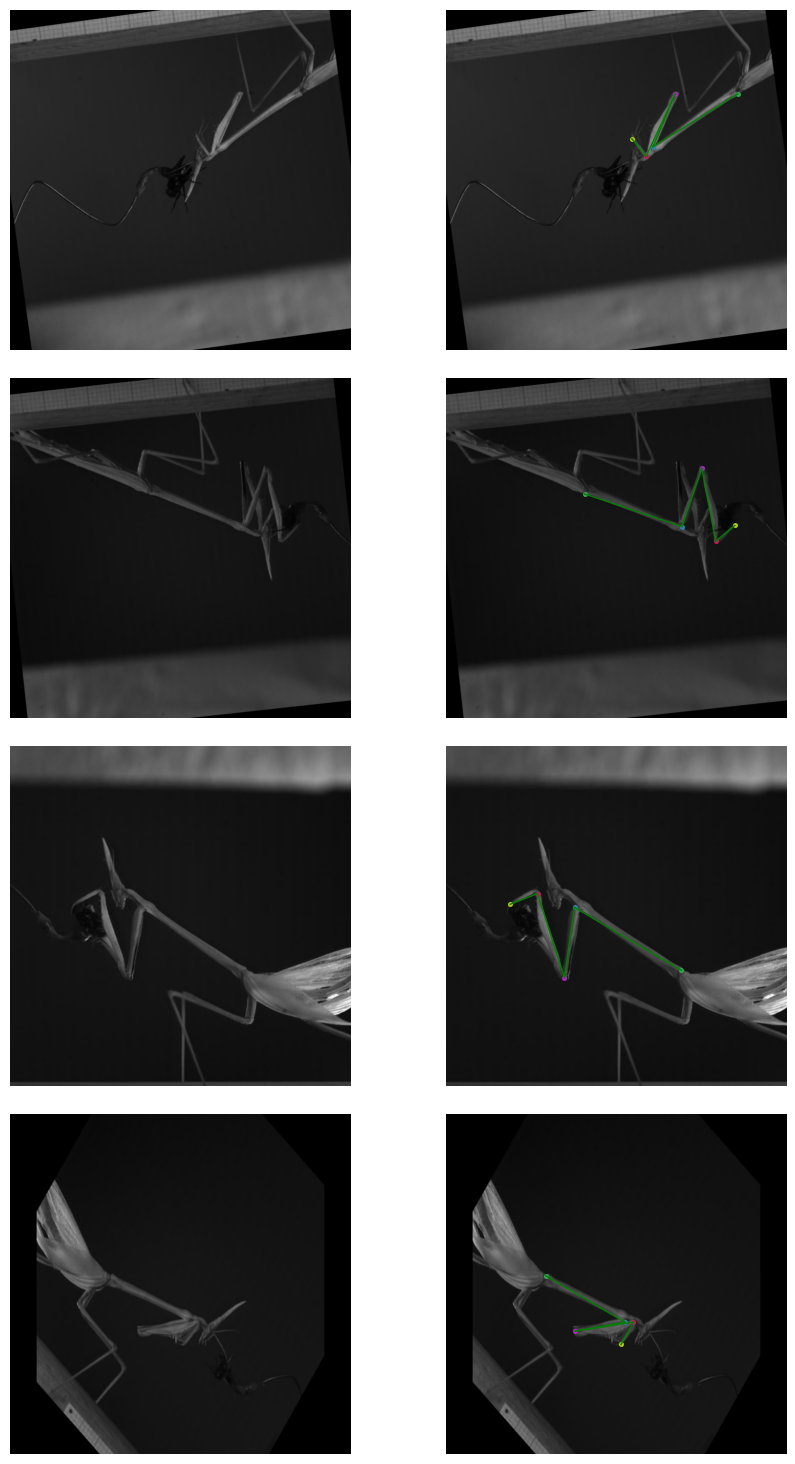

In [ ]:
train_dataset = KeyPointsDataset(
    train_keys, train_aug, workers=2, use_multiprocessing=True
)
validation_dataset = KeyPointsDataset(
    validation_keys, test_aug, train=False, workers=2, use_multiprocessing=True
)

test_dataset= KeyPointsDataset(
    test_keys, test_aug, train=False, workers=2, use_multiprocessing=True
)

print(f"Total batches in training set: {len(train_dataset)}")
print(f"Total batches in validation set: {len(validation_dataset)}")
print(f"Total batches in test set: {len(test_dataset)}")

sample_images, sample_keypoints = next(iter(train_dataset))
#assert sample_keypoints.max() == 1.0
#assert sample_keypoints.min() == 0.0

sample_keypoints = sample_keypoints[:4].reshape(-1, 5, 2) * IMG_SIZE
visualize_keypoints(sample_images[:4], sample_keypoints)

## Model building

tbd

In [ ]:
def get_model():
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    backbone = keras.applications.MobileNetV2(
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )

    backbone.trainable = False

    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)

    x = layers.Dropout(0.3)(x)
    x = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=4, strides=1, activation="relu"
    )(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=3, strides=1, activation="relu"
    )(x)

    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    outputs = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=3, strides=1, activation="sigmoid"
    )(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")


Our custom network is fully-convolutional which makes it more parameter-friendly than the
same version of the network having fully-connected dense layers.

In [ ]:
get_model().summary()

<ipython-input-17-8a4a82442041>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  backbone = keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "keypoint_detector"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 640, 640, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 640, 640, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 640, 640, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 20, 20, 1280)        │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 20, 1280)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d (SeparableConv2D)   │ (None, 17, 17, 10)          │          33,290 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 8, 8, 10)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_1 (SeparableConv2D) │ (None, 6, 6, 10)            │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 3, 3, 10)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_2 (SeparableConv2D) │ (None, 1, 1, 10)            │             200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,291,674 (8.74 MB)

 Trainable params: 33,690 (131.60 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Model compilation and training

Defining a callback function to check overfitting and fitting the model

callback function

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=50,
)

Train the model

In [ ]:
model = get_model()
model.compile(loss="mse", optimizer=keras.optimizers.Adam(1e-4))
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=100, callbacks=[callback])

Save the model

In [ ]:
model.save('/content/drive/MyDrive/MantisModels/mantisAI.keras')

## Training Performance

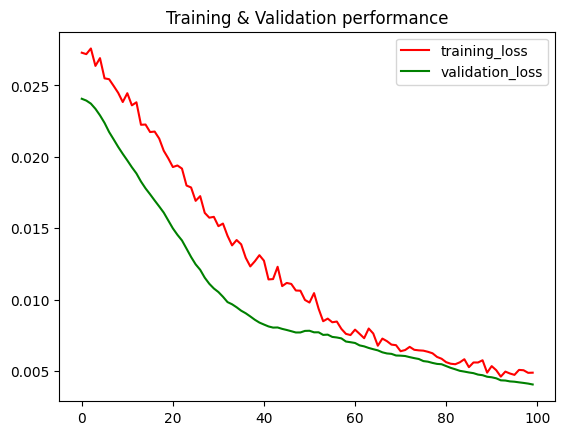

In [ ]:
#plot model training and validation
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='training_loss')
plt.plot(epochs, val_loss, 'g', label='validation_loss')
plt.title('Training & Validation performance')
plt.legend(loc=0)
plt.savefig('/content/drive/MyDrive/MantisModels/training_validation_loss220.png')
plt.show()



## Make predictions and visualize them

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Ground-truth


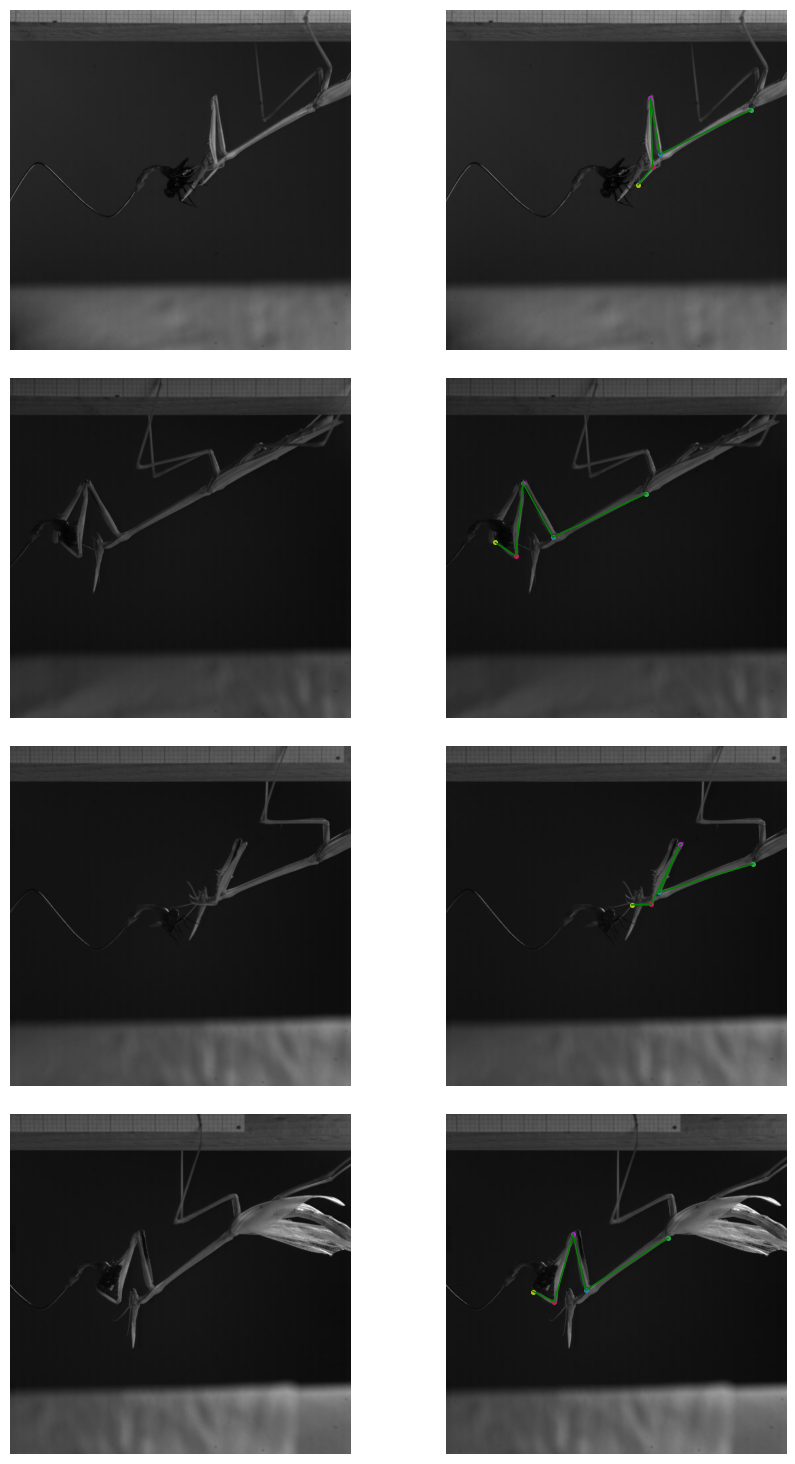

Predictions


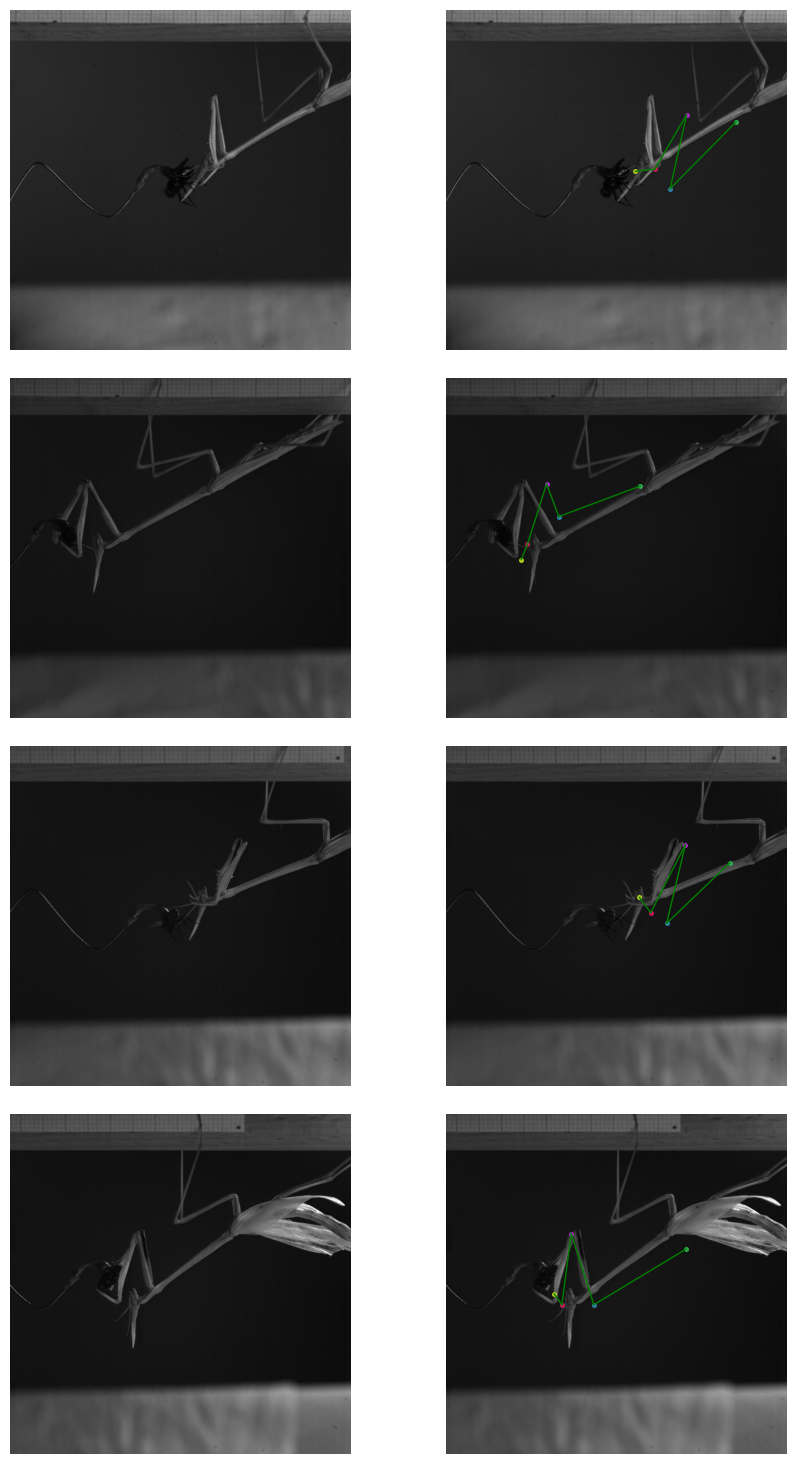

In [ ]:
sample_val_images, sample_val_keypoints = next(iter(validation_dataset))
sample_val_images = sample_val_images[:4]
sample_val_keypoints = sample_val_keypoints[:4].reshape(-1, 5, 2) * IMG_SIZE
predictions = model.predict(sample_val_images).reshape(-1, 5, 2) * IMG_SIZE

# Ground-truth
print ("Ground-truth")
visualize_keypoints(sample_val_images, sample_val_keypoints)

# Predictions
print ("Predictions")
visualize_keypoints(sample_val_images, predictions)

# Predictions on Test Set

In [ ]:
predictions = model.predict(test_dataset)

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 405ms/step


In [ ]:
# prompt: create a code that save the predicitions with the according image name as well as the ground truth values to a json file

import json

# Assuming 'predictions' is your array of predictions and 'test_dataset' is your test dataset
# and 'test_keys' contains the file names in test dataset

# Create a list to store the results
results = []

# Iterate through the predictions and filenames
for i, pred in enumerate(predictions):
    # Reshape the prediction as done previously (assuming a 5 keypoints setup)
    reshaped_pred = pred.reshape(-1, 5, 2) * IMG_SIZE

    # Get the corresponding image filename
    image_filename = test_keys[i]

    # Get the ground truth keypoints
    data = get_mantis(image_filename)
    ground_truth_keypoints = np.array(data["joints"])[:, :2] # Extract only x,y coordinates

    # Append to the result list
    results.append({
        "image_name": image_filename,
        "predictions": reshaped_pred.tolist(),  # Convert numpy to list
        "ground_truth": ground_truth_keypoints.tolist()  # Convert numpy to list
    })


# Save the results to a JSON file
with open('/content/drive/MyDrive/MantisModels/predictions.json', 'w') as f:
    json.dump(results, f, indent=4)